In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_columns', None)
plt.style.use('seaborn-v0_8')


In [2]:
# Путь к файлу
data_path = "../data/raw/cars_raw.csv"

# Загрузка данных
df = pd.read_csv(data_path)

df.head()


,id,region,price,year,manufacturer,model,condition,fuel,transmission,drive;
0,7316814884,auburn,33590.0,2014.0,gmc,sierra 1500 crew cab slt,good,gas,other,;
1,7316814758,auburn,22590.0,2010.0,chevrolet,silverado 1500,good,gas,other,;
2,7316814989,auburn,39590.0,2020.0,chevrolet,silverado 1500 crew,good,gas,other,;
3,7316743432,auburn,30990.0,2017.0,toyota,tundra double cab sr,good,gas,other,;
4,7316356412,auburn,15000.0,2013.0,ford,f-150 xlt,excellent,gas,automatic,rwd;


In [3]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29926 entries, 0 to 29925
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   id            29926 non-null  object 
 1   region        29818 non-null  object 
 2   price         29818 non-null  float64
 3   year          29669 non-null  float64
 4   manufacturer  28545 non-null  object 
 5   model         29407 non-null  object 
 6   condition     17681 non-null  object 
 7   fuel          29653 non-null  object 
 8   transmission  29738 non-null  object 
 9   drive;        29818 non-null  object 
dtypes: float64(2), object(8)
memory usage: 2.3+ MB


In [4]:
df.describe(include='all')


,id,region,price,year,manufacturer,model,condition,fuel,transmission,drive;
count,29926,29818,2.981800e+04,29669.000000,28545,29407,17681,29653,29738,29818
unique,29926,34,NaN,NaN,39,5832,6,5,3,5
top,7316814884,fresno / madera,NaN,NaN,ford,f-150,good,gas,automatic,;
freq,1,2967,NaN,NaN,4989,542,8501,23852,23092,8626
mean,NaN,NaN,1.956172e+04,2011.658465,NaN,NaN,NaN,NaN,NaN,NaN
std,NaN,NaN,1.746860e+04,10.003451,NaN,NaN,NaN,NaN,NaN,NaN
min,NaN,NaN,0.000000e+00,1900.000000,NaN,NaN,NaN,NaN,NaN,NaN
25%,NaN,NaN,6.995000e+03,2009.000000,NaN,NaN,NaN,NaN,NaN,NaN
50%,NaN,NaN,1.670000e+04,2014.000000,NaN,NaN,NaN,NaN,NaN,NaN
75%,NaN,NaN,2.899500e+04,2017.000000,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
df.isnull().sum()


id                  0
region            108
price             108
year              257
manufacturer     1381
model             519
condition       12245
fuel              273
transmission      188
drive;            108
dtype: int64

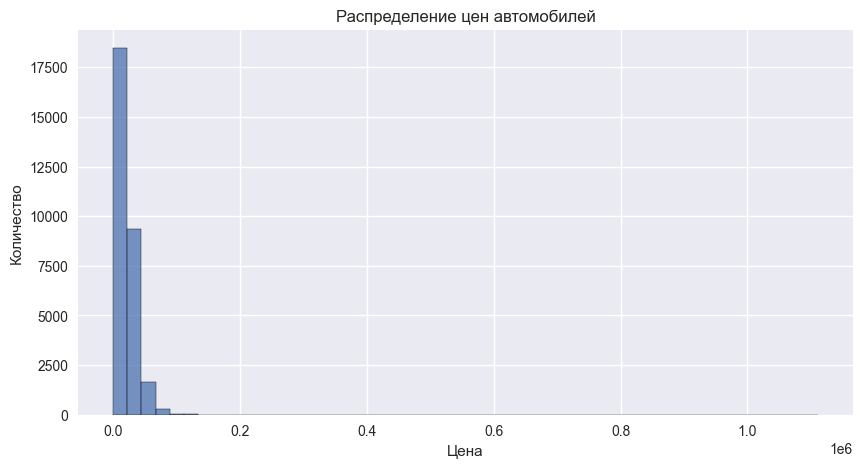

In [6]:
plt.figure(figsize=(10,5))
sns.histplot(df['price'], bins=50)
plt.title("Распределение цен автомобилей")
plt.xlabel("Цена")
plt.ylabel("Количество")
plt.show()


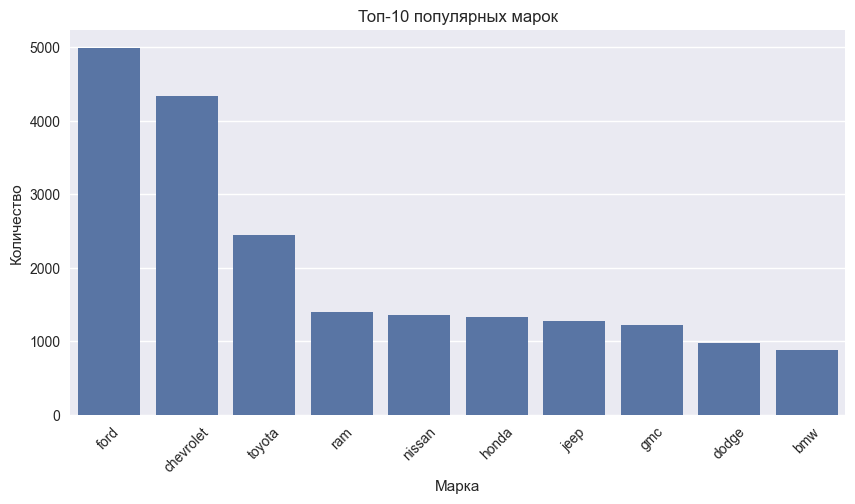

In [7]:
top10_brands = df['manufacturer'].value_counts().head(10)

plt.figure(figsize=(10,5))
sns.barplot(x=top10_brands.index, y=top10_brands.values)
plt.title("Топ-10 популярных марок")
plt.xlabel("Марка")
plt.ylabel("Количество")
plt.xticks(rotation=45)
plt.show()


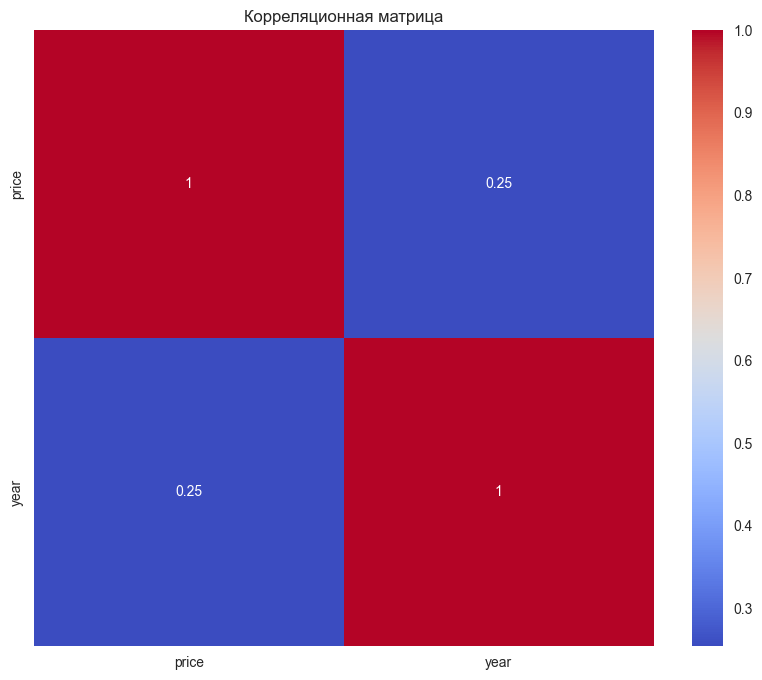

In [8]:
plt.figure(figsize=(10,8))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap="coolwarm")
plt.title("Корреляционная матрица")
plt.show()


In [9]:
# 1) Уберём строки без ключевых полей (price, year, manufacturer, model)
df_clean = df.dropna(subset=['price', 'year', 'manufacturer', 'model']).copy()

# 2) Уберём нулевые и отрицательные цены
df_clean = df_clean[df_clean['price'] > 0]

# 3) Отфильтруем экстремальные значения по цене по квантилям (1% и 99%)
q1, q99 = df_clean['price'].quantile([0.01, 0.99])
df_clean = df_clean[(df_clean['price'] >= q1) & (df_clean['price'] <= q99)]

# 4) Оставим адекватные годы (например, от 1980 до 2025)
df_clean = df_clean[(df_clean['year'] >= 1980) & (df_clean['year'] <= 2025)]

# 5) Приведём год к int
df_clean['year'] = df_clean['year'].astype(int)

df_clean.head()


,id,region,price,year,manufacturer,model,condition,fuel,transmission,drive;
0,7316814884,auburn,33590.0,2014,gmc,sierra 1500 crew cab slt,good,gas,other,;
1,7316814758,auburn,22590.0,2010,chevrolet,silverado 1500,good,gas,other,;
2,7316814989,auburn,39590.0,2020,chevrolet,silverado 1500 crew,good,gas,other,;
3,7316743432,auburn,30990.0,2017,toyota,tundra double cab sr,good,gas,other,;
4,7316356412,auburn,15000.0,2013,ford,f-150 xlt,excellent,gas,automatic,rwd;


In [10]:
# возраст авто (пусть базовый год 2024)
df_clean['car_age'] = 2024 - df_clean['year']

# логарифм цены (смягчает сильную асимметрию распределения)
df_clean['log_price'] = np.log1p(df_clean['price'])

# биннинг года выпуска (категориальный признак)
df_clean['year_bin'] = pd.cut(
    df_clean['year'],
    bins=[1980, 2000, 2010, 2015, 2020, 2025],
    labels=['<=2000', '2001-2010', '2011-2015', '2016-2020', '2021-2024'],
    include_lowest=True
)

df_clean[['price', 'log_price', 'year', 'car_age', 'year_bin']].head()


,price,log_price,year,car_age,year_bin
0,33590.0,10.422013,2014,10,2011-2015
1,22590.0,10.025307,2010,14,2001-2010
2,39590.0,10.586357,2020,4,2016-2020
3,30990.0,10.341452,2017,7,2016-2020
4,15000.0,9.615872,2013,11,2011-2015


In [11]:
output_path = "../data/processed/cars_processed.csv"
df_clean.to_csv(output_path, index=False)
output_path


'../data/processed/cars_processed.csv'